# Machine Learning - Ensemble Models
- 여러 예측 모델을 연결하여 더 강력한 모델을 만드는 것
- 편향, 잡음 및 분산으로 인한 오류를 막고, Overfitting 방지

In [1]:
import warnings
from IPython.display import display, HTML

In [2]:
### HTML display 조정
display(HTML("<style>.container {width :98% !important;}</style>"))

### Warning 제거
warnings.filterwarnings('ignore')

## Package Load

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, auc

## Data Load

In [5]:
### Breast cancer dataset: classification
breast = pd.read_csv('./dataset/breast-cancer.csv')
breast["diagnosis"] = np.where(breast["diagnosis"]=="M", 1, 0) # target 변수 처리

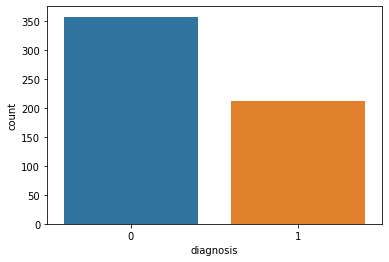

In [6]:
sns.countplot(x='diagnosis', data=breast)
plt.show()

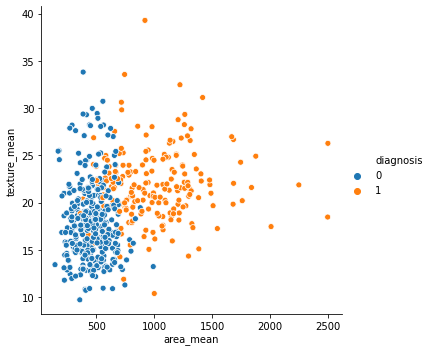

In [7]:
sns.relplot(x='area_mean', y='texture_mean', hue='diagnosis', data=breast)
plt.show()

In [8]:
breast_x = breast.iloc[:, 2:]
breast_y = breast.iloc[:, 1]

In [9]:
### Car dataset: regression
car = pd.read_csv('./dataset/CarPrice_Assignment.csv')
car_num = car.select_dtypes(['number'])
car_num.head()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


In [10]:
car_x = car_num[list(car_num.columns.difference(['car_ID', 'symboling', 'price']))]
car_y = car_num['price']

## Bagging
- Bootstrap aggregating
- 크기가 같은 표본을 단순 임의 복원추출하여 여러 개의 모델을 만듦 (표본 비율은 max_samples 파라미터로 지정 가능. default 1)
- Bootstraping -> Modeling -> Voting
- 분산이 적은 모델을 만드는 것이 목표이고, 각 과정은 병렬로 이루어짐
- oob_score
    - Out of bag
    - Bootstrap 시 선택되지 않은 데이터 (약 36.8%)로 모델 평가
- Pasting: Bagging과 동일 과정을 거치나, 비복원추출 진행하는 것이 다른 점. 성능이 떨어져서 잘 사용하지 않음

### (1) Classifier

In [11]:
x = breast[["area_mean", "area_worst"]]
y = breast["diagnosis"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(398, 2) (171, 2) (398,) (171,)


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [13]:
### Modeling
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier())
pred = clf.fit(x_train, y_train).predict(x_test)
print("Accuracy Score : ", clf.score(x_test, pred))

Accuracy Score :  1.0


In [14]:
pd.DataFrame(confusion_matrix(y_test, pred), index=['True[0]', 'True[1]'], columns=['Pred[0]','Pred[1]'])

,Pred[0],Pred[1]
True[0],102,5
True[1],10,54


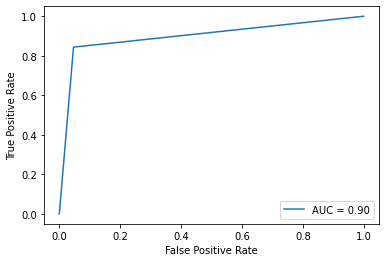

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc) # plot_roc_curve(clf, x_test, y_test)
display.plot()
plt.show()

In [16]:
### oob_score
# Out of bag
# Bootstrap 시 선택되지 않은 데이터로 평가한 결과
clf_oob = BaggingClassifier(base_estimator=DecisionTreeClassifier(), oob_score=True)
oob = clf_oob.fit(x, y).oob_score_
print(oob)

0.9173989455184535


### (2) Regressor
- 각 예측 결과를 평균하는 방식으로 모델 결과 집계
- 중앙값을 사용하는 경우 Robust Bagging

In [17]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [18]:
reg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), oob_score=True)
reg = reg.fit(car_x, car_y)
reg.oob_score_

0.8027684297480392

## Boosting
- Bootstrap 샘플링 과정에서, 분류가 잘못된 데이터의 가중치를 높임
- 이전 모델이 갖는 오차를 줄이는 방향으로, 다음 모델을 순차적으로 생성함
- 예측력이 약한 모델을 결합에 강한 예측모형을 만드는 것
- Overfitting 위험 있음

### (1) AdaBoost
- Adaptive Boosting
- 초기 버전 부스팅
- 잔차에 따라 데이터의 가중치 조절 -> 가중치가 다음 모델의 입력이 됨

#### Classifier

In [19]:
x = breast[["area_mean", "texture_mean"]]
y = breast["diagnosis"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(398, 2) (171, 2) (398,) (171,)


In [20]:
from sklearn.ensemble import AdaBoostClassifier

In [21]:
clf = AdaBoostClassifier(base_estimator=None) # default는 DecisionTreeClassifier(max_depth=1)
pred = clf.fit(x_train, y_train).predict(x_test)
print("정확도 : ", clf.score(x_test, y_test))

정확도 :  0.9122807017543859


In [22]:
pred = clf.predict(x_test)

print(confusion_matrix(y_test, pred))
print('정확도\t{}%'.format(round(accuracy_score(y_test, pred) * 100, 2)))
print('정밀도\t{}%'.format(round(precision_score(y_test, pred) * 100, 2)))
print('재현율\t{}%'.format(round(recall_score(y_test, pred) * 100, 2)))
print('F1\t{}%'.format(round(f1_score(y_test, pred) * 100, 2)))

[[102   5]
 [ 10  54]]
정확도	91.23%
정밀도	91.53%
재현율	84.38%
F1	87.8%


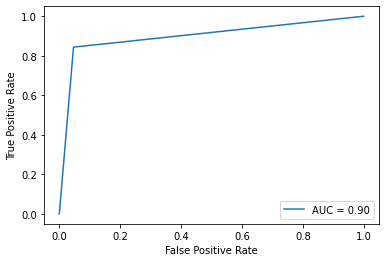

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr)) # plot_roc_curve(clf, x_test, y_test)
display.plot()
plt.show()

In [24]:
importances = clf.feature_importances_
column_nm = pd.DataFrame(list(x.columns))
feature_importances = pd.concat([column_nm, pd.DataFrame(importances)], axis=1)
feature_importances.columns = ['feature_nm', 'importances']
feature_importances

,feature_nm,importances
0,area_mean,0.56
1,texture_mean,0.44


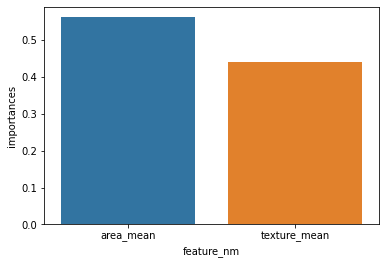

In [25]:
plt.xticks(list(range(len(column_nm))), x.columns)
sns.barplot(feature_importances.feature_nm, feature_importances.importances)
plt.show()

#### Regressor

In [26]:
x_train, x_test, y_train, y_test = train_test_split(car_x, car_y, test_size=0.3, random_state=1)

In [27]:
from sklearn.ensemble import AdaBoostRegressor

In [28]:
reg = AdaBoostRegressor(base_estimator=None) # default는 DecisionTreeRegressor(max_depth=3)
pred = reg.fit(x_train, y_train).predict(x_test)

print('MSE\t{}'.format(round(mean_squared_error(y_test, pred), 3)))
print('MAE\t{}'.format(round(mean_absolute_error(y_test, pred), 3)))
print('ACC\t{}%'.format(round(reg.score(x_test, y_test) * 100, 3)))

MSE	5572821.864
MAE	1812.088
ACC	90.769%


In [29]:
importances = reg.feature_importances_
column_nm = pd.DataFrame(list(car_x.columns))
feature_importances = pd.concat([column_nm, pd.DataFrame(importances)], axis=1)
feature_importances.columns = ['feature_nm', 'importances']
feature_importances

,feature_nm,importances
0,boreratio,0.013926
1,carheight,0.004858
2,carlength,0.005987
3,carwidth,0.055211
4,citympg,0.008660
5,compressionratio,0.003548
6,curbweight,0.093058
7,enginesize,0.628452
8,highwaympg,0.050024
9,horsepower,0.085948


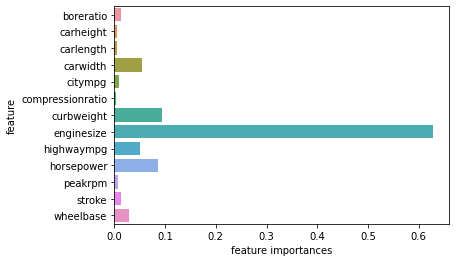

In [30]:
sns.barplot(feature_importances.importances, feature_importances.feature_nm)
plt.yticks(list(range(len(column_nm))), car_x.columns)
plt.xlabel("feature importances")
plt.ylabel("feature")
plt.show()

### (2) Gradient Boosting
- Gradient descent를 이용하여 오류 데이터 가중치 업데이트 (전체 데이터의 오차 최적화)
- 가중치 조정 대신 Pseudo residual을 학습하도록 함
- 트리 기반 모델 사용
- max_depth는 일반적으로 5 이하로 사용하고 (default 3), learning_rate로 오차 보정 정도와 모델의 복잡성 제어 (값이 클수록 강한 보정하여 복잡한 모델이 됨. default 0.1)

#### Classifier

In [31]:
x_train, x_test, y_train, y_test = train_test_split(breast_x, breast_y, test_size=0.2, random_state=156)

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

In [33]:
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(x_train, y_train)
gb_pred = gb_clf.predict(x_test)

print('GBM 정확도: {0:.4f}'.format(accuracy_score(y_test, gb_pred)))

GBM 정확도: 0.9649


#### Regressor

In [34]:
x_train, x_test, y_train, y_test = train_test_split(car_x, car_y, test_size=0.3, random_state=1)

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

In [36]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42) # n_estimator가 클수록 많은 Tree를 이용하게 되고, over-fitting의 위험도도 높아짐
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=1.0, random_state=42)

gbrt.fit(x_train, y_train)
gbrt_slow.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, random_state=42)

In [37]:
gbrt_pred = gbrt.predict(x_test)
gbrt_slow_pred = gbrt_slow.predict(x_test)

rmse = mean_squared_error(y_test, gbrt_pred, squared=False)
rmse_slow = mean_squared_error(y_test, gbrt_slow_pred, squared=False)
print(f'RMSE n_estimator 3: {round(rmse, 4)}, RMSE n_estimator 100: {round(rmse_slow, 4)}') # n_estimator 100일때 RMSE가 더 높음

RMSE n_estimator 3: 2877.1349, RMSE n_estimator 100: 2952.7825


### (3) XGBoost
- eXtra Gradient Boosting
- Stochasitc Gradient Boosting: Gradient Boosting에 랜덤 요소 추가
- subsample로 샘플링 데이터 비율 조정, eta로 모델 복잡성 제어

#### Classifier

In [38]:
x_train, x_test, y_train, y_test=train_test_split(breast_x, breast_y, test_size=0.2, random_state=156)

In [39]:
# !pip install xgboost
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

In [40]:
xgb_wrapper = xgb.XGBClassifier(n_estimators=40, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(x_train, y_train)
w_preds = xgb_wrapper.predict(x_test)
w_pred_proba = xgb_wrapper.predict_proba(x_test)[:, 1]

In [41]:
print('오차 행렬\n', confusion_matrix(y_test, w_preds))
print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{3:.4f}'.format(
    accuracy_score(y_test, w_preds), precision_score(y_test, w_preds), recall_score(y_test, w_preds), f1_score(y_test, w_preds), roc_auc_score(y_test, w_pred_proba)))

오차 행렬
 [[75  2]
 [ 3 34]]
정확도: 0.9561, 정밀도: 0.9444, 재현율: 0.9189, F1:0.9315, AUC:0.9315


In [42]:
xgb_wrapper = xgb.XGBClassifier(n_estimators=40, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=[(x_test, y_test)], verbose=True)

ws100_preds = xgb_wrapper.predict(x_test)
ws100_pred_proba = xgb_wrapper.predict_proba(x_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


In [43]:
print('오차 행렬\n', confusion_matrix(y_test, ws100_preds))
print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{3:.4f}'.format(
    accuracy_score(y_test, ws100_preds), precision_score(y_test, ws100_preds), recall_score(y_test, ws100_preds), f1_score(y_test, ws100_preds), roc_auc_score(y_test, ws100_pred_proba)))

오차 행렬
 [[75  2]
 [ 3 34]]
정확도: 0.9561, 정밀도: 0.9444, 재현율: 0.9189, F1:0.9315, AUC:0.9315


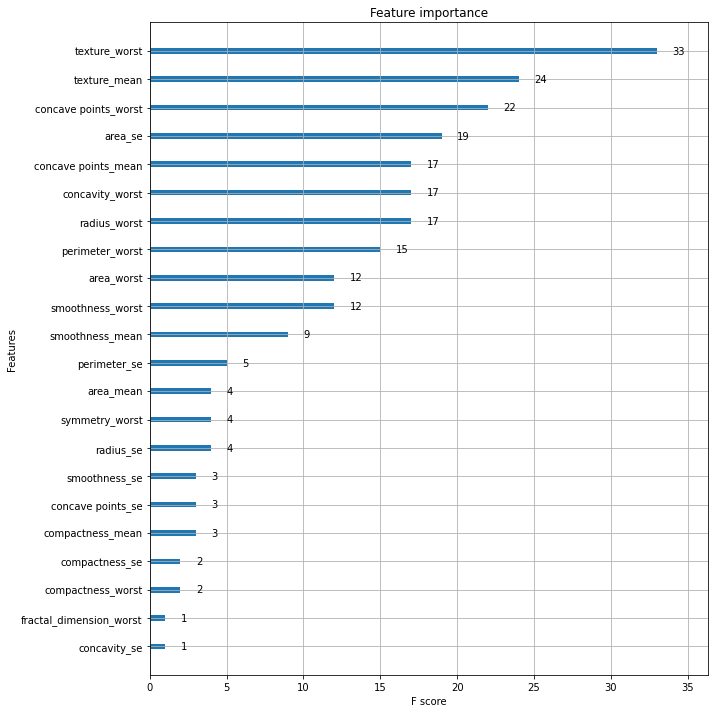

In [44]:
fig, ax = plt.subplots(figsize=(10, 12)) 
plot_importance(xgb_wrapper, ax=ax)
plt.show()

In [45]:
# !pip install hyperopt
from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, Trials

In [46]:
### Bayesian optimization
# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)}

In [47]:
# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, x_train, y_train, scoring='accuracy', cv=3)
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [48]:
trial_val = Trials()
best = fmin(fn=objective_func, space=xgb_search_space, algo=tpe.suggest, max_evals=50, trials=trial_val, rstate=np.random.RandomState(9))
print('best:', best)

100%|██████████| 50/50 [00:04<00:00, 12.00it/s, best loss: -0.9670762170326479]
best: {'colsample_bytree': 0.5811103711796605, 'learning_rate': 0.15180675941399624, 'max_depth': 8.0, 'min_child_weight': 1.0}


In [49]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5), int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.58111, learning_rate:0.15181, max_depth:8, min_child_weight:1


In [50]:
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']), colsample_bytree=round(best['colsample_bytree'], 5))
xgb_wrapper.fit(x_train, y_train, early_stopping_rounds=50, eval_metric='logloss', eval_set=[(x_test, y_test)], verbose=True)

[0]	validation_0-logloss:0.578221
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.492012
[2]	validation_0-logloss:0.420106
[3]	validation_0-logloss:0.369392
[4]	validation_0-logloss:0.327529
[5]	validation_0-logloss:0.293799
[6]	validation_0-logloss:0.262687
[7]	validation_0-logloss:0.243564
[8]	validation_0-logloss:0.221154
[9]	validation_0-logloss:0.204395
[10]	validation_0-logloss:0.19117
[11]	validation_0-logloss:0.180603
[12]	validation_0-logloss:0.168258
[13]	validation_0-logloss:0.160961
[14]	validation_0-logloss:0.153644
[15]	validation_0-logloss:0.144174
[16]	validation_0-logloss:0.140235
[17]	validation_0-logloss:0.136454
[18]	validation_0-logloss:0.133027
[19]	validation_0-logloss:0.129182
[20]	validation_0-logloss:0.123826
[21]	validation_0-logloss:0.121787
[22]	validation_0-logloss:0.121513
[23]	validation_0-logloss:0.116898
[24]	validation_0-logloss:0.115334
[25]	validation_0-logloss:0.11054
[26]	validation_0-logloss:0.106849

XGBClassifier(colsample_bytree=0.58111, learning_rate=0.15181, max_depth=8,
              n_estimators=400)

In [51]:
pred = xgb_wrapper.predict(x_test)
pred_proba = xgb_wrapper.predict_proba(x_test)[:, 1]

print(confusion_matrix(y_test, pred))
print('정확도\t{}%'.format(round(accuracy_score(y_test, pred) * 100, 2)))
print('정밀도\t{}%'.format(round(precision_score(y_test, pred) * 100, 2)))
print('재현율\t{}%'.format(round(recall_score(y_test, pred) * 100, 2)))
print('F1\t{}%'.format(round(f1_score(y_test, pred) * 100, 2)))
print('AUC\t{}%'.format(round(roc_auc_score(y_test, pred_proba) * 100, 2)))

[[76  1]
 [ 3 34]]
정확도	96.49%
정밀도	97.14%
재현율	91.89%
F1	94.44%
AUC	99.44%


#### Regressor

In [52]:
x_train, x_test, y_train, y_test = train_test_split(car_x, car_y, test_size=0.3, random_state=1)

In [53]:
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(x_train, y_train)
y_pred = xgb_reg.predict(x_test)

print("Validation MSE:", mean_squared_error(y_test, y_pred))

[17:39:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 5385298.514696932


In [54]:
xgb_reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=2) # early stopping
y_pred = xgb_reg.predict(x_test)

print("Validation MSE:", mean_squared_error(y_test, y_pred))

[17:39:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:13465.5
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:12236.6
[2]	validation_0-rmse:11143.1
[3]	validation_0-rmse:10146.5
[4]	validation_0-rmse:9263.07
[5]	validation_0-rmse:8461.7
[6]	validation_0-rmse:7756.52
[7]	validation_0-rmse:7119.63
[8]	validation_0-rmse:6559.8
[9]	validation_0-rmse:6052.46
[10]	validation_0-rmse:5602.4
[11]	validation_0-rmse:5190.21
[12]	validation_0-rmse:4820.41
[13]	validation_0-rmse:4521.26
[14]	validation_0-rmse:4242.78
[15]	validation_0-rmse:4011.61
[16]	validation_0-rmse:3809.6
[17]	validation_0-rmse:3618.51
[18]	validation_0-rmse:3458.91
[19]	validation_0-rmse:3307.93
[20]	validation_0-rmse:3195.41
[21]	validation_0-rmse:3097.14
[22]	validation_0-rmse:2995.8
[23]	validation_0-rmse:2904.61
[24]	validation_0-rmse:2822.47
[25]	validation_0-rmse:2754.93
[26]	validation_0-rmse:2692.6

### (4) LightGBM
- XGBoost보다 더 빠른 학습 속도
- Leaf Wise tree 분할: 비균형 트리 생성
- Regressor에서 quantile 옵션 적용 가능 (objective = 'quantile', alpha = quantile)

In [55]:
# !pip install lightgbm
from lightgbm import plot_importance
from lightgbm import early_stopping
from lightgbm import LGBMClassifier

In [56]:
x_train, x_test, y_train, y_test=train_test_split(breast_x, breast_y, test_size=0.2, random_state=156)

In [57]:
# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=40, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
lgbm_wrapper.fit(x_train, y_train, eval_metric="logloss", eval_set=[(x_train, y_train), (x_test, y_test)], callbacks=[early_stopping(stopping_rounds=10)])

[1]	training's binary_logloss: 0.62499	training's binary_logloss: 0.62499	valid_1's binary_logloss: 0.600521	valid_1's binary_logloss: 0.600521
Training until validation scores don't improve for 10 rounds.
[2]	training's binary_logloss: 0.587995	training's binary_logloss: 0.587995	valid_1's binary_logloss: 0.566786	valid_1's binary_logloss: 0.566786
[3]	training's binary_logloss: 0.555412	training's binary_logloss: 0.555412	valid_1's binary_logloss: 0.537032	valid_1's binary_logloss: 0.537032
[4]	training's binary_logloss: 0.525887	training's binary_logloss: 0.525887	valid_1's binary_logloss: 0.510051	valid_1's binary_logloss: 0.510051
[5]	training's binary_logloss: 0.497961	training's binary_logloss: 0.497961	valid_1's binary_logloss: 0.484612	valid_1's binary_logloss: 0.484612
[6]	training's binary_logloss: 0.473236	training's binary_logloss: 0.473236	valid_1's binary_logloss: 0.462044	valid_1's binary_logloss: 0.462044
[7]	training's binary_logloss: 0.449603	training's binary_loglos

LGBMClassifier(learning_rate=0.05, n_estimators=40)

In [58]:
preds = lgbm_wrapper.predict(x_test)
pred_proba = lgbm_wrapper.predict_proba(x_test)[:, 1]
    
print('오차 행렬\n', confusion_matrix(y_test, preds))
print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{3:.4f}'.format(
    accuracy_score(y_test, preds), precision_score(y_test, preds), recall_score(y_test, preds), f1_score(y_test, preds), roc_auc_score(y_test, pred_proba)))

오차 행렬
 [[75  2]
 [ 3 34]]
정확도: 0.9561, 정밀도: 0.9444, 재현율: 0.9189, F1:0.9315, AUC:0.9315


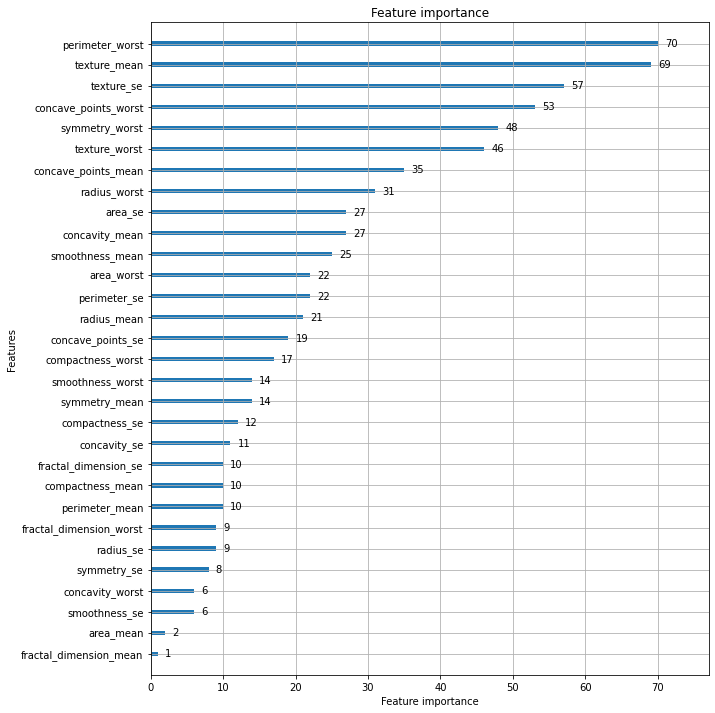

In [59]:
# plot_importance()를 이용하여 feature 중요도 시각화
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

## Random Forest
- Tree에 무작위성 부여
- Bagging에 랜덤 과정을 추가한 Tree 기반 모델 (Random성이 있으므로, 동일한 결과를 내려면 random_state 변수 설정 필요)
- 예측변수들을 임의로 추출하여 Bootstrap 샘플 구성
- input 변수가 많을수록 좋은 성능
- 병렬 실행 가능하고, feature 개수가 적어 계산비용이 낮음
- Bagging의 OOB 데이터로 추가 데이터 없이 모델 검증 가능하고, Tree 특성으로 데이터 스케일에 구애받지 않음
- 결과에 대한 직관적인 해석은 어려우며, 고차원의 sparse 데이터에는 잘 작동하지 않음
- Extra-trees (Extremely randomized tree)
    - 가지 분할 시, 최적 임계값이 아닌 랜덤 설정한 임계값 사용
    - 후보 특성을 무작위로 분할
    - Bootstrap을 기본적으로는 적용하지 않음 (bootstrap=True로 적용 가능)
    - Random Forest보다 계산 비용이 낮지만, 무작위 분할로 인해 트리 개수가 많아져야 함 -> Random Forest보다 비선호
    - ExtraTreeClassifier, ExtreTreeRegressor

### (1) Classifier

In [60]:
x = breast[["area_mean", "texture_mean"]]
y = breast["diagnosis"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(398, 2) (171, 2) (398,) (171,)


In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
clf = RandomForestClassifier(n_estimators=100, min_samples_split=5)

pred = clf.fit(x_train, y_train).predict(x_test)
print("정확도: ", clf.score(x_test, y_test))

정확도:  0.8947368421052632


In [63]:
print(confusion_matrix(y_test, pred))
print('정확도\t{}%'.format(round(accuracy_score(y_test, pred) * 100, 2)))
print('정밀도\t{}%'.format(round(precision_score(y_test, pred) * 100, 2)))
print('재현율\t{}%'.format(round(recall_score(y_test, pred) * 100, 2)))
print('F1\t{}%'.format(round(f1_score(y_test, pred) * 100, 2)))

[[102   5]
 [ 13  51]]
정확도	89.47%
정밀도	91.07%
재현율	79.69%
F1	85.0%


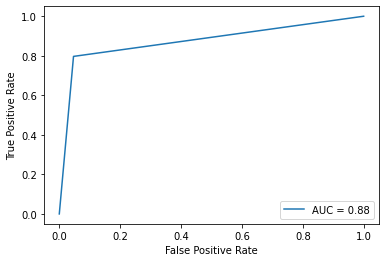

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr)) # plot_roc_curve(clf, x_test, y_test)
display.plot()
plt.show()

In [65]:
importances = clf.feature_importances_
column_nm = pd.DataFrame(["area_mean", "texture_mean"])
feature_importances = pd.concat([column_nm, pd.DataFrame(importances)], axis=1)
feature_importances.columns = ['feature_nm', 'importances']
feature_importances

,feature_nm,importances
0,area_mean,0.691479
1,texture_mean,0.308521


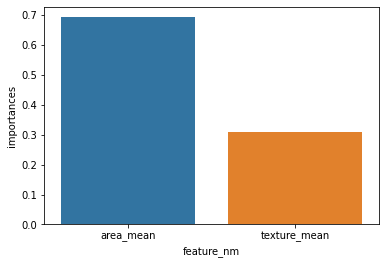

In [66]:
sns.barplot(feature_importances.feature_nm, feature_importances.importances)
plt.xticks(list(range(len(column_nm))), x.columns)
plt.show()

### (2) Regressor

In [67]:
x_train, x_test, y_train, y_test = train_test_split(car_x, car_y, test_size=0.3, random_state=1)

In [68]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
reg = RandomForestRegressor()
pred = reg.fit(x_train, y_train).predict(x_test)

mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
acc = reg.score(x_test, y_test)

print('MSE\t{}'.format(round(mse,3)))
print('MAE\t{}'.format(round(mae,3)))
print('RMSE\t{}'.format(round(rmse,3)))
print('ACC\t{}%'.format(round(acc *100,3)))

MSE	4256471.201
MAE	1363.349
RMSE	2063.122
ACC	92.949%


In [70]:
importances = reg.feature_importances_
column_nm = pd.DataFrame(list(car_x.columns))
feature_importances = pd.concat([column_nm, pd.DataFrame(importances)], axis=1)
feature_importances.columns = ['feature_nm', 'importances']
feature_importances

,feature_nm,importances
0,boreratio,0.003998
1,carheight,0.004373
2,carlength,0.006718
3,carwidth,0.022718
4,citympg,0.007142
5,compressionratio,0.004663
6,curbweight,0.188881
7,enginesize,0.659641
8,highwaympg,0.055085
9,horsepower,0.015216


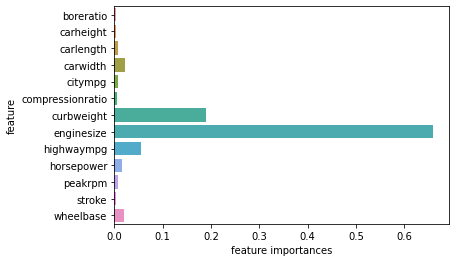

In [71]:
sns.barplot(feature_importances.importances, feature_importances.feature_nm)
plt.yticks(list(range(len(column_nm))), car_x.columns)
plt.xlabel("feature importances")
plt.ylabel("feature")
plt.show()

## Voting
- 여러 모델의 결과를 가지고 투표를 통해 최종 output 생서
- Voting의 결과물이 반드시 좋은 것은 아님

### (1) Classifier
- Hard voting: 다수결 원칙. 모델의 가중치를 조정하기 용이
- Soft voting: 각 Class의 확률을 평균하여 결정
    - 확률이 높은 투표에 조금 더 비중이 있음
    - 성능이 대체적으로 더 좋은 편

In [72]:
x_train, x_test, y_train, y_test = train_test_split(breast_x, breast_y, test_size=0.2, random_state=156)

In [73]:
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [74]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42, probability=True)

In [75]:
### hard voting
voting_clf = VotingClassifier(estimators=[('lr', lr_clf), ('knn', knn_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(x_train, y_train)

for clf in (lr_clf, knn_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9473684210526315
KNeighborsClassifier 0.9473684210526315
RandomForestClassifier 0.9473684210526315
SVC 0.9298245614035088
VotingClassifier 0.9473684210526315


In [76]:
### soft voting
voting_clf = VotingClassifier(estimators=[('lr', lr_clf), ('knn', knn_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')
voting_clf.fit(x_train, y_train)

for clf in (lr_clf, knn_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9473684210526315
KNeighborsClassifier 0.9473684210526315
RandomForestClassifier 0.9473684210526315
SVC 0.9298245614035088
VotingClassifier 0.9473684210526315


### (2) Regressor

In [77]:
x_train, x_test, y_train, y_test = train_test_split(car_x, car_y, test_size=0.3, random_state=1)

In [78]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [79]:
# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    return np.sqrt(np.mean(squared_error))

In [80]:
# 개별 모델 성능 평가
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

rf_reg = RandomForestRegressor(n_estimators=50)
gbm_reg = GradientBoostingRegressor(n_estimators=50)
xgb_reg = XGBRegressor(n_estimators=50)
lgbm_reg = LGBMRegressor(n_estimators=50)

# XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
for model in [lr_reg, ridge_reg, lasso_reg, rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    model.fit(x_train.values, y_train.values)
    pred = model.predict(x_test.values)

    print('###',model.__class__.__name__,'###')
    rmsle_val = rmsle(y_test, pred)
    rmse_val = mean_squared_error(y_test, pred, squared=False)
    mae_val = mean_absolute_error(y_test, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

### LinearRegression ###
RMSLE: 0.238, RMSE: 3361.353, MAE: 2378.951
### Ridge ###
RMSLE: 0.237, RMSE: 3367.771, MAE: 2406.361
### Lasso ###
RMSLE: 0.238, RMSE: 3361.348, MAE: 2378.949
### RandomForestRegressor ###
RMSLE: 0.134, RMSE: 2079.663, MAE: 1349.201
### GradientBoostingRegressor ###
RMSLE: 0.146, RMSE: 2337.001, MAE: 1570.422
[17:39:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.148, RMSE: 2349.790, MAE: 1587.698
### LGBMRegressor ###
RMSLE: 0.181, RMSE: 3144.793, MAE: 1814.483


In [81]:
# 개별 모델 Voting
vo_reg = VotingRegressor(estimators=[('LR', lr_reg), ('Ridge', ridge_reg), ('Lasso', lasso_reg), ('RF', rf_reg), ('GBM', gbm_reg), ('XGB', xgb_reg), ('LGBM', lgbm_reg)])
vo_reg.fit(x_train, y_train)
pred = vo_reg.predict(x_test)

rmsle_val = rmsle(y_test, pred)
rmse_val = mean_squared_error(y_test, pred, squared=False)
mae_val = mean_absolute_error(y_test, pred)
print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

[17:39:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE: 0.177, RMSE: 2545.086, MAE: 1674.900


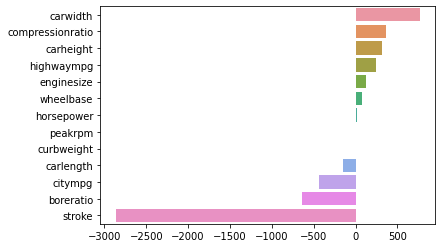

In [82]:
# Linear Regression coef 파악
coef = pd.Series(lr_reg.coef_, index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.show()

## Stacking
- Stacked generalization
- 여러 모델의 예측을 취합하는 새로운 모델(Blender, Meta learner) 훈련
- 수행 시간 대비 성능이 좋은 편은 아님

### (1) Classifier

In [83]:
x_train, x_test, y_train, y_test = train_test_split(breast_x, breast_y, test_size=0.2, random_state=0)

In [84]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [85]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)

In [86]:
# 개별 모델들을 학습. 
knn_clf.fit(x_train, y_train)
rf_clf.fit(x_train, y_train)
dt_clf.fit(x_train, y_train)
ada_clf.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [87]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(x_test)
rf_pred = rf_clf.predict(x_test)
dt_pred = dt_clf.predict(x_test)
ada_pred = ada_clf.predict(x_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9298
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [88]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [89]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9825


In [90]:
### CV set stacking
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds=5):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__ , ' model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t폴드 세트: ', folder_counter, ' 시작')
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index] 
        X_te = X_train_n.iloc[valid_index]  

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr, y_tr) 
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [91]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, x_train, y_train, x_test)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, x_train, y_train, x_test)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, x_train, y_train, x_test)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, x_train, y_train, x_test)

KNeighborsClassifier  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작
RandomForestClassifier  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작
DecisionTreeClassifier  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작
AdaBoostClassifier  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작


In [92]:
stack_final_x_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
stack_final_x_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)

print('원본 학습 피처 데이터 Shape:', x_train.shape, '원본 테스트 피처 Shape:', x_test.shape)
print('스태킹 학습 피처 데이터 Shape:', stack_final_x_train.shape, '스태킹 테스트 피처 데이터 Shape:', stack_final_x_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [93]:
lr_final.fit(stack_final_x_train, y_train)
stack_final = lr_final.predict(stack_final_x_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9825


### (2) Regressor

In [94]:
x_train, x_test, y_train, y_test = train_test_split(car_x, car_y, test_size=0.3, random_state=1)

In [95]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

LinearRegression RMSE: 3361.353
Ridge RMSE: 3367.771
Lasso RMSE: 3361.353


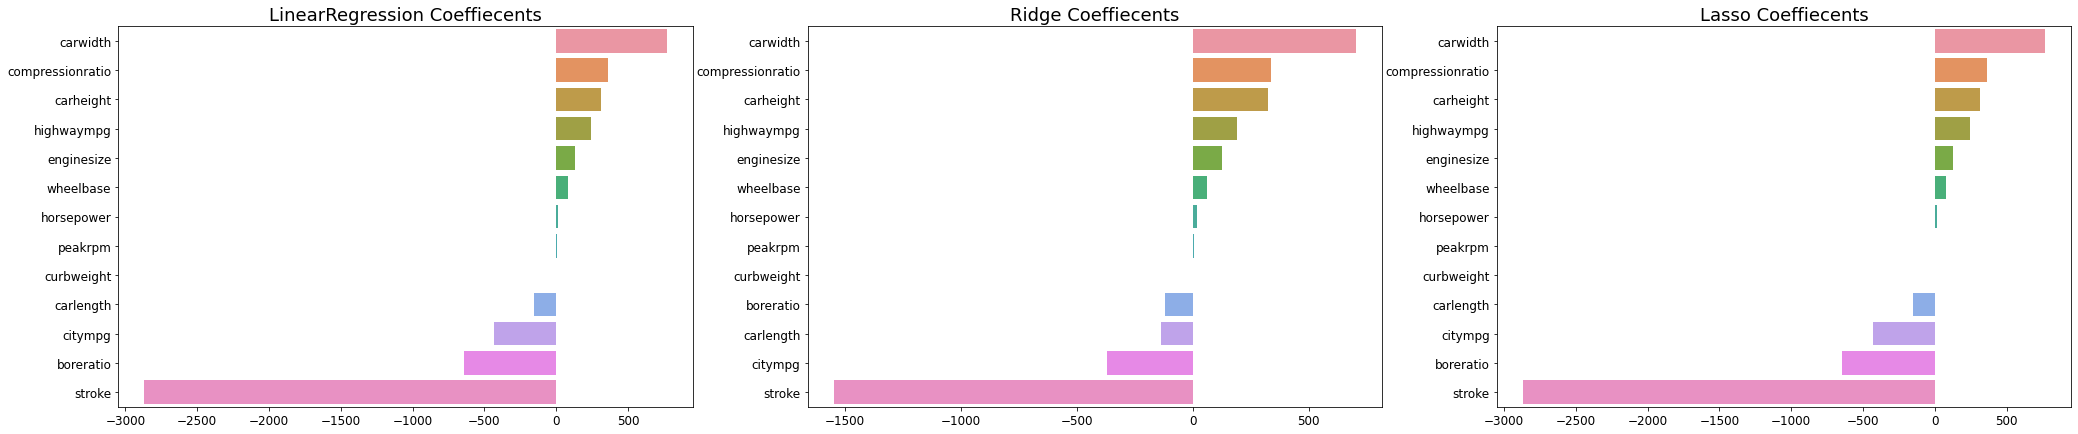

In [96]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)

ridge_reg = Ridge(alpha=10)
ridge_reg.fit(x_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]

rmses = []
for model in models:
    rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)
    rmses.append(rmse)
    print('{0} RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))

# 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
fig, axs = plt.subplots(figsize=(35, 7), nrows=1, ncols=3)

# 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
for i_num, model in enumerate(models): 
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=car_x.columns)

    # 상위 10개, 하위 10개 coefficient 추출
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
        
    coef_concat = pd.concat( [coef_high , coef_low] )
    # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
    axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=18)
    axs[i_num].tick_params(axis="y")
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
        label.set_fontsize(12)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

In [97]:
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
xgb_reg.fit(x_train, y_train)

lgbm_reg = LGBMRegressor(n_estimators=100, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
lgbm_reg.fit(x_train, y_train)

[17:39:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(colsample_bytree=0.4, learning_rate=0.05, num_leaves=4,
              reg_lambda=10, subsample=0.6)

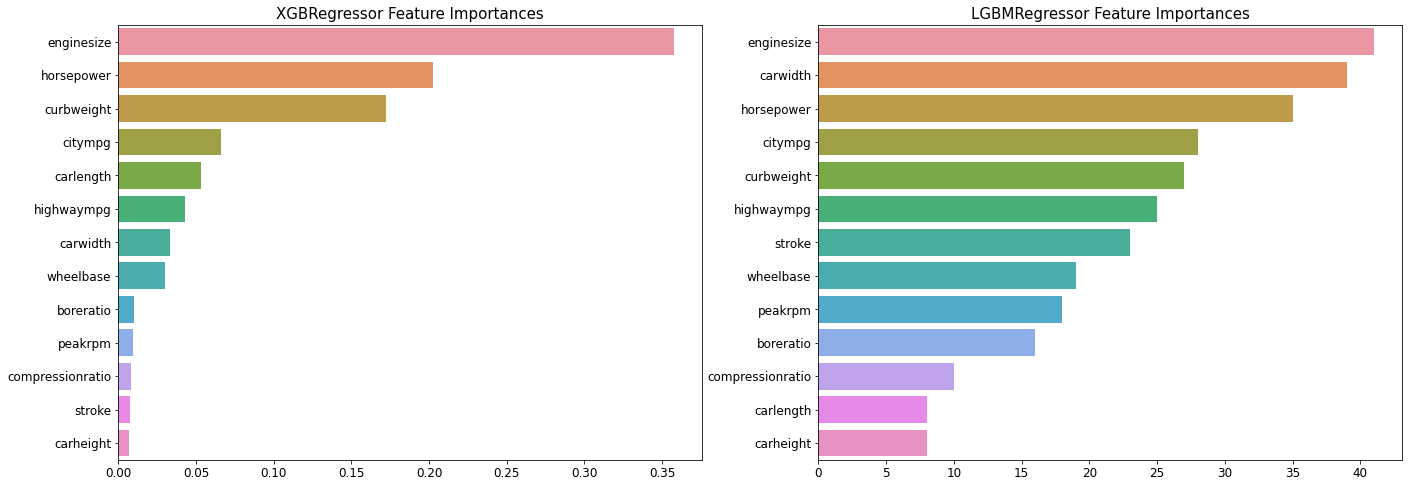

In [98]:
# 앞 예제에서 print_best_params()가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [xgb_reg, lgbm_reg]
fig, axs = plt.subplots(figsize=(23, 8), nrows=1, ncols=2)

# 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
for i_num, model in enumerate(models):
    # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
    ftr_top20 = pd.Series(model.feature_importances_, index=car_x.columns).sort_values(ascending=False)[:20]
    axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=15)
    
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
        label.set_fontsize(12)
    sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

In [99]:
# 개별 모델 예측
ridge_pred = ridge_reg.predict(x_test)
lasso_pred = lasso_reg.predict(x_test)
xgb_pred = xgb_reg.predict(x_test)
lgbm_pred = lgbm_reg.predict(x_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.2 * ridge_pred + 0.2 * lasso_pred + 0.3 * xgb_pred + 0.3 * lgbm_pred
preds = {'최종 혼합': pred, 'Ridge': ridge_pred, 'Lasso': lasso_pred, 'XGB': xgb_pred, 'LGBM': lgbm_pred}

#최종 혼합 모델, 개별모델의 RMSE 값 출력
for key in preds.keys():
    print('{0} 모델의 RMSE: {1}'.format(key, mean_squared_error(y_test , preds[key], squared=False)))

최종 혼합 모델의 RMSE: 2669.029528556948
Ridge 모델의 RMSE: 3367.7711076113733
Lasso 모델의 RMSE: 3361.352523200533
XGB 모델의 RMSE: 2249.945449864291
LGBM 모델의 RMSE: 3164.5053966774626


In [100]:
# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, x_train, y_train, x_test, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, x_train, y_train, x_test, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, x_train, y_train, x_test, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, x_train, y_train, x_test, 5)

Ridge  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작
Lasso  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작
XGBRegressor  model 시작
	폴드 세트:  0  시작
[17:39:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	폴드 세트:  1  시작
[17:39:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	폴드 세트:  2  시작
[17:39:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	폴드 세트:  3  시작
[17:39:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	폴드 세트:  4  시작
[17:39:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작


In [101]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
stack_final_x_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
stack_final_x_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(stack_final_x_train, y_train)
print('스태킹 회귀 모델의 최종 RMSE 값은:', mean_squared_error(y_test, meta_model_lasso.predict(stack_final_x_test), squared=False))

스태킹 회귀 모델의 최종 RMSE 값은: 2209.6210246968926
